## Create Graph Plots of the Vector Images in Tempest

In [1]:
from itertools import groupby
from operator import itemgetter
from matplotlib import pyplot as plt
import os

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 150

colors = {
    "TURQOI":"CYAN",
    "PDIWHI":"WHITE",
    "PDIRED":"RED",
    "PDIYEL":"YELLOW",
    "":"WHITE",
}

def scvec(old_x,old_y,color,x,y,i=0):
    c = "BLACK" if i == 0 else colors.get(color,color)
    vec=(x-old_x,y-old_y,c)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def calvec(old_x,old_y,x,y,CALBRITE):
    vec=(x-old_x,y-old_y,CALBRITE)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def vctr(color,x,y,i=""):
    x,y=int(x,16),int(y,16)
    if i == "0":
        return (x,y,"BLACK")
    return (x,y,colors.get(color,color))

def parse_calvec_parms(parms):
    x,y = [x.replace('.','') for x in parms[0].split(',')]
    x = 0x00 if x == "NXE" else int(x,16)
    y = int(y,16)
    return (x,y)

def parse_vector_commands(vector_data,default_color="red"):
    # Read in the vector commands from the Tempest source code
    # and translate them into a series of vectors, i.e. a  list of 
    # tuples of the form (x,y,color).
    # This list can then be transformed into a series of x,y co-ordinates
    # for plotting on a graph.
    color = ""
    vecs = []
    old_x,old_y = 0,0
    CALBRITE = "BLACK"
    for l in vector_data.splitlines():
        if not l.strip():
            continue
        tokens = l.strip().split()
        cmd, parms = tokens[0],tokens[1:]
        if cmd in ["ICVEC","ICALVE"]:
            vecs+=[(0,0,"BLACK")]
            old_x,old_y=0,0
        elif cmd == "CNTR":
            vecs+=[(0,0,"BLACK")]
        elif cmd == "CSTAT":
            color = parms[0]
        elif cmd == "VCTR":
            parms = parms[0].split(',')
            vecs+=[vctr(color,*parms)]
        elif cmd == "VEC":
            # A 0,0 origin is implicit.
            if len(vecs) == 0:
                vecs+=[(0,0,default_color)]    
            parms = parms[0].split(',')
            vecs+=[vctr(default_color,*parms)]
        elif cmd == "SCVEC":
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
        elif cmd == "VDOT":
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd == "SCDOT":
            # SCVEC
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd in [".BRITE=VARBRT",".BRITE =VARBRT"]:
            CALBRITE=default_color
        elif cmd in [".BRITE=0",".BRITE =0"]:
            CALBRITE="BLACK"
        elif cmd == "CALVEC":
            x,y = parse_calvec_parms(parms)
            vec,old_x,old_y = calvec(old_x,old_y,x,y,CALBRITE)
            vecs+=[vec]
    return vecs

def vectors_to_coords(vectors):
    # Turns a series of vectors into a series of x,y co-ordinates
    # or vertices.
    xs,ys,cs=[],[],[]
    px,py,pc=0,0,None
    for x,y,c in vectors:
        # If we're changing color, add a vertex with the
        # new color at the old position.
        if pc and c != pc:
            xs+=[px]
            ys+=[py]
            cs+=[c]
        # Calculate the position of the new vertex
        px+=x
        py+=y
        xs+=[px]
        ys+=[py]
        cs+=[c]
        pc=c
    return list(zip(xs,ys,cs))



In [15]:
def plot_vertices(verts,file_name,points="",linewidth=3.0):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    ax.set_aspect('equal', adjustable='box') 
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)
    plt.savefig(f"vector_images/vec_image_plot_{file_name}.png", bbox_inches='tight')
    plt.axis('off')
    plt.savefig(f"vector_images/vec_image_{file_name}.png", bbox_inches='tight')

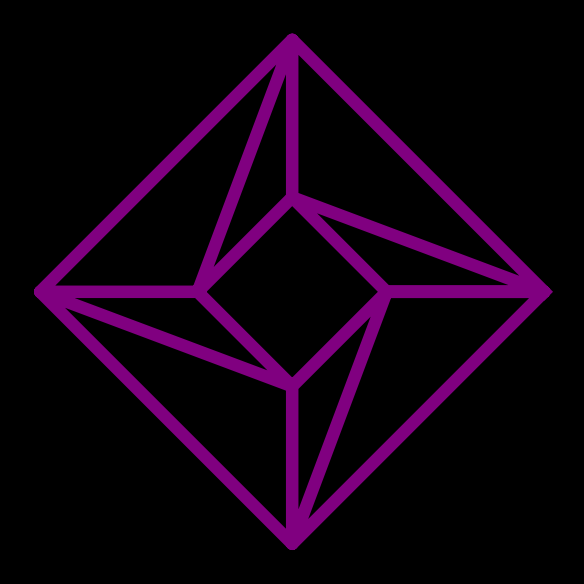

In [16]:
vector_data = """
TANKR:
	ICVEC
    CSTAT PURPLE
	SCVEC 20,0,0
GENTNK:	
	SCVEC 0,20,CB
	SCVEC 0,0C,CB
	SCVEC 20,0,CB
	SCVEC 0C,0,CB
	SCVEC 0,0C,CB
	SCVEC -0C,0,CB
	SCVEC 0,20,CB
	SCVEC -20,0,CB
	SCVEC -0C,0,CB
	SCVEC 0,-0C,CB
	SCVEC -20,0,CB
	SCVEC 0,-20,CB
	SCVEC 0,-0C,CB
	SCVEC 0C,0,CB
	SCVEC 0,-20,CB
	SCVEC 20,0,CB
	SCVEC 0C,0,CB
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"tankr",points="",linewidth=6.0)


I had never noticed that the tankers containing pulsars and fuses have a little badge on the front indicating their contents!

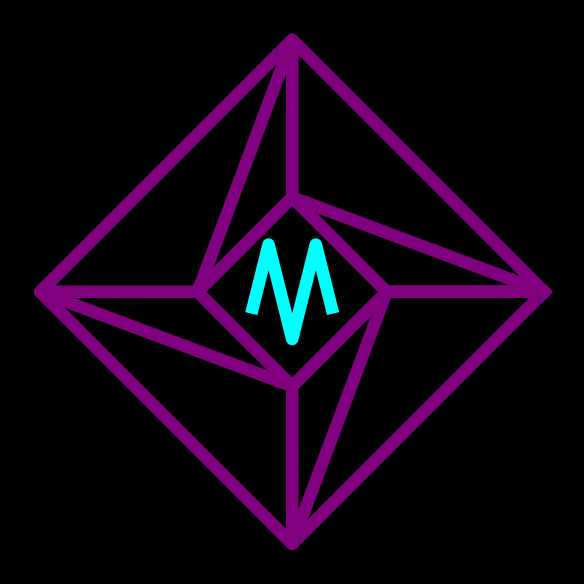

In [17]:
vector_data = """
TANKP:			;TANKER OF PULSARS
	ICVEC
	CSTAT TURQOI
	SCVEC -5,-2,0
	SCVEC -3,6,CB
	SCVEC 0,-6,CB
	SCVEC 3,6,CB
	SCVEC 5,-2,CB
	SCVEC 20,0,0
	JMPL GENTNK
GENTNK:	
    CSTAT PURPLE
	SCVEC 0,20,CB
	SCVEC 0,0C,CB
	SCVEC 20,0,CB
	SCVEC 0C,0,CB
	SCVEC 0,0C,CB
	SCVEC -0C,0,CB
	SCVEC 0,20,CB
	SCVEC -20,0,CB
	SCVEC -0C,0,CB
	SCVEC 0,-0C,CB
	SCVEC -20,0,CB
	SCVEC 0,-20,CB
	SCVEC 0,-0C,CB
	SCVEC 0C,0,CB
	SCVEC 0,-20,CB
	SCVEC 20,0,CB
	SCVEC 0C,0,CB
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"tankp",points="",linewidth=6.0)


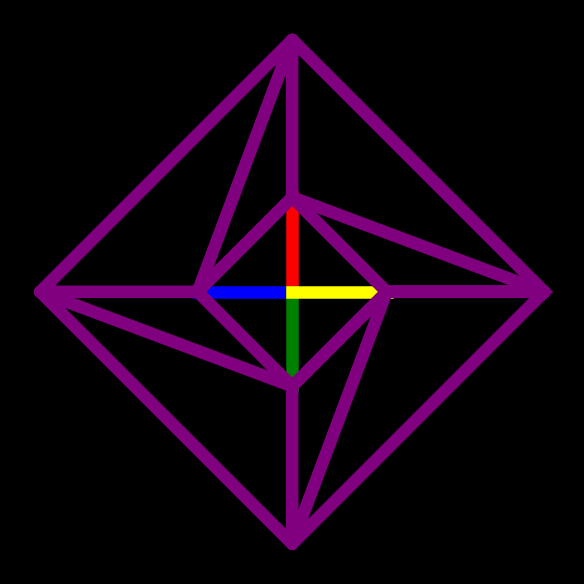

In [18]:
vector_data = """
TANKF:				;TANKER OF FUSES
	ICVEC
	CSTAT BLUE
	SCVEC -0C,0,CB
	SCVEC 0,0C,0
	CSTAT RED
	SCVEC 0,0,CB
	CSTAT GREEN
	SCVEC 0,-0C,CB
	SCVEC 0,0,0
	CSTAT YELLOW
	SCVEC 0C,0,CB
	SCVEC 20,0,0
GENTNK:	
    CSTAT PURPLE
	SCVEC 0,20,CB
	SCVEC 0,0C,CB
	SCVEC 20,0,CB
	SCVEC 0C,0,CB
	SCVEC 0,0C,CB
	SCVEC -0C,0,CB
	SCVEC 0,20,CB
	SCVEC -20,0,CB
	SCVEC -0C,0,CB
	SCVEC 0,-0C,CB
	SCVEC -20,0,CB
	SCVEC 0,-20,CB
	SCVEC 0,-0C,CB
	SCVEC 0C,0,CB
	SCVEC 0,-20,CB
	SCVEC 20,0,CB
	SCVEC 0C,0,CB
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"tankf",points="",linewidth=6.0)
